In [1]:
!pip install wandb
import wandb
import os
import yaml
from shutil import copytree, ignore_patterns
import xml.etree.ElementTree as ET

In [2]:
root_path = '/kaggle/input/fruit-images-for-object-detection/'
os.listdir(root_path)

['train_zip', 'test_zip']

In [3]:
train_data_path = os.path.join(root_path,'train_zip/train')
test_data_path = os.path.join(root_path,'test_zip/test')

In [4]:
'''All .xml and .jpg file names'''
train_data_description = os.listdir(train_data_path)
test_data_description = os.listdir(test_data_path)

In [5]:
'''train_annotaion_file_paths and test_annotation_file_paths contains all .xml file paths
   train_image_file_paths and test_image_file_paths contains all .jpg file paths'''
train_annotation_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.xml' in i]
train_image_file_paths = [os.path.join(train_data_path,i) for i in train_data_description if '.jpg' in i]

test_annotation_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.xml' in i]
test_image_file_paths = [os.path.join(test_data_path,i) for i in test_data_description if '.jpg' in i]

In [6]:
print(f'length of training Data {len(train_image_file_paths)}, length of test data {len(test_image_file_paths)}')

length of training Data 240, length of test data 60


In [7]:
'''Creating required directories to labels'''
for i in ['train/labels','test/labels']:
    os.makedirs(os.path.join('/kaggle/working/object_detection/',i))

In [8]:
'''Copying all images to required directories'''
copytree(train_data_path,'/kaggle/working/object_detection/train/images/',ignore = ignore_patterns('*.xml'))
copytree(test_data_path,'/kaggle/working/object_detection/test/images/',ignore = ignore_patterns('*.xml'))

'/kaggle/working/object_detection/test/images/'

In [9]:
def convert_xml_to_txt(label_path,xml_file,class_dict,destination_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    x=root.find('filename').text
    txt_file = x.replace('.jpg','.txt')
    txt_file = os.path.join(destination_file,txt_file)
    with open(txt_file,'w') as f:
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in class_dict:
                continue
            class_id = class_dict[class_name]
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            xmax = int(bbox.find('xmax').text)
            ymin = int(bbox.find('ymin').text)
            ymax = int(bbox.find('ymax').text)
            
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)
            
            x_center = (xmin + xmax) / 2 / image_width if image_width != 0 else (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2 / image_height if image_height != 0 else (ymin + ymax) / 2
            width = (xmax - xmin) / image_width if image_width != 0 else (xmax - xmin)
            height = (ymax - ymin) / image_height if image_height != 0 else (ymax - ymin)
             
            line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"
            f.write(line)

In [11]:
class_dict = {'apple':0,'banana':1,'orange':2}


dest_path = '/kaggle/working/object_detection/train/labels/'
for i in train_annotation_file_paths:
    convert_xml_to_txt(train_data_path,i,class_dict,dest_path)
    

dest_path = '/kaggle/working/object_detection/test/labels/'
for i in test_annotation_file_paths:
    convert_xml_to_txt(test_data_path,i,class_dict,dest_path)

In [12]:
'''yaml file path, you can check the file'''
yaml_path = "/kaggle/input/d/vishnu1233/yamldata/data.yaml"

In [13]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 15.4 MB/s eta 0:00:0000:01


In [14]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [15]:
'''I am using wandb website to visualize YOLOv8 model
    use your key from wandb website or use any other way to visualize'''
wandb.login(key='***************')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
'''Training model'''
results = model.train(data=yaml_path, epochs=50, batch=4)

Ultralytics YOLOv8.0.122 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/d/vishnu1233/yamldata/data.yaml, epochs=50, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 65.6MB/s]
AMP: checks passed ✅
train: Scanning /kaggle/working/object_detection/train/labels... 240 images, 0 backgrounds, 33 corrupt: 100%|██████████| 240/240 [00:00<00:00, 1211.42it/s]
train: WARNING ⚠️ /kaggle/working/object_detection/train/images/apple_1.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      169.5         182         323         334]
train: WARNING ⚠️ /kaggle/working/object_detection/train/images/apple_17.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        348         479         470         442]
train: WARNING ⚠️ /kaggle/working/object_detection/train/images/apple_20.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      240.5         276         435         442]
train: WARNING ⚠️ /kaggle/working/object_detection/train/images/apple_28.jpg: ignoring corrupt im

In [17]:
'''Predicting single image to check how good model works'''
Test_image_results = model('/kaggle/working/object_detection/test/images/apple_77.jpg')


image 1/1 /kaggle/working/object_detection/test/images/apple_77.jpg: 512x640 5 apples, 49.4ms
Speed: 1.8ms preprocess, 49.4ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


In [18]:
Test_image_results[0].boxes.data.tolist()

[[204.91636657714844,
  148.17369079589844,
  293.84747314453125,
  229.0,
  0.7829483151435852,
  0.0],
 [121.53400421142578,
  131.98934936523438,
  213.01705932617188,
  223.2222137451172,
  0.669944703578949,
  0.0],
 [12.342788696289062,
  21.426103591918945,
  89.69338989257812,
  100.79479217529297,
  0.3934321403503418,
  0.0],
 [71.75804138183594,
  64.31503295898438,
  152.3566436767578,
  150.80032348632812,
  0.353829950094223,
  0.0],
 [14.841777801513672,
  24.305418014526367,
  68.28119659423828,
  80.24966430664062,
  0.34568214416503906,
  0.0]]

In [20]:
import cv2
import matplotlib.pyplot as plt
'''Load the image'''
image = cv2.imread('/kaggle/input/fruit-images-for-object-detection/test_zip/test/apple_77.jpg')
copy_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_dict = {0:'apple',1:'banana',2:'orange'}
'''Iterate over the bounding box predictions'''
for bbox in Test_image_results[0].boxes.data.tolist():
    x1, y1, x2, y2,confidence,label = bbox

    '''Draw rectangle'''
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    '''Add label'''
    cv2.putText(image, img_dict[int(label)], (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
'''Convert BGR image to RGB'''
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

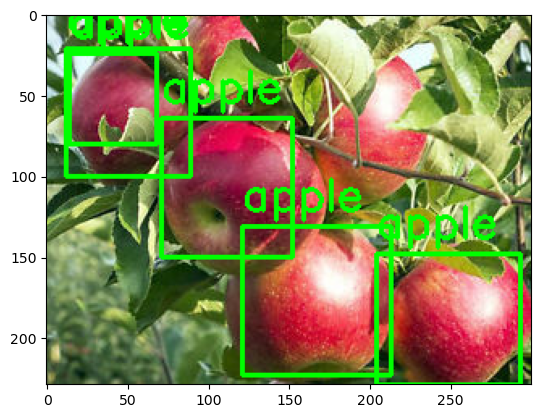

In [21]:
'''Display the image using matplotlib'''
plt.imshow(image_rgb)

In [22]:
'''It is a simple way of using yolov8 model, Modify it as you want it to'''

'It is a simple way of using yolov8 model, Modify it as you want it to'